In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import yfinance as yf
import fredapi as fa
from datetime import date, timedelta
from Exposure_Report import Exposure
import numpy as np
import matplotlib.pyplot as plt
import Useful_Functions as u
from statsmodels.tsa.stattools import adfuller
from scipy.stats.mstats import normaltest

fred = fa.Fred('4fb0ce271d0f66f4b5b3904b4aaf1dd0')



In [27]:

# regular_factors_and_rates
factor_df = pd.read_csv("regular_factors_and_rates.csv", index_col="Date")
#factor_df = pd.read_csv("sectors_and_rates.csv", index_col="Date")

forward = 30
#train_df = factor_df[:cutoff]
#test_df = factor_df[cutoff:]
# , "SP-500"
exposure = Exposure(factor_df, 252, forward, ['Real Yield', 'Yield Curve'])



In [28]:

cutoff = int(len(factor_df)*.6)
factor_df[:cutoff].corr()


,DEFAULT,QUALITY,MOMENTUM,BOOK_TO_PRICE,SIZE,CASH_TO_ASSETS,Real Yield,Yield Curve
DEFAULT,1.000000,-0.824604,-0.560571,-0.042621,0.089240,-0.066548,-0.006389,-0.014001
QUALITY,-0.824604,1.000000,0.294027,0.260322,-0.155806,-0.040090,0.017269,0.001717
MOMENTUM,-0.560571,0.294027,1.000000,-0.167171,-0.069155,0.174602,0.014754,0.029991
BOOK_TO_PRICE,-0.042621,0.260322,-0.167171,1.000000,0.137758,-0.536394,-0.001324,-0.017441
SIZE,0.089240,-0.155806,-0.069155,0.137758,1.000000,0.107158,0.011304,0.018830
CASH_TO_ASSETS,-0.066548,-0.040090,0.174602,-0.536394,0.107158,1.000000,0.012811,0.032016
Real Yield,-0.006389,0.017269,0.014754,-0.001324,0.011304,0.012811,1.000000,0.629972
Yield Curve,-0.014001,0.001717,0.029991,-0.017441,0.018830,0.032016,0.629972,1.000000


In [29]:

raw_df = exposure.forward_returns_daily_raw.dropna()


regular_df = exposure.forward_returns_monthly.dropna()
regular_df['top_factor'] = [ regular_df.loc[i].iloc[:-2].sort_values().index[-1] for i in  regular_df.index]

labels = {fact : num for num, fact in enumerate(regular_df.columns[:-2])}
labels_reverse = {num : fact for num, fact in enumerate(regular_df.columns[:-2])}

#labels_bunched = {"DEFAULT" : 0, "QUALITY" : 1, "MOMENTUM" : }


regular_df['top_factor'] = regular_df['top_factor'].map(labels)
consideration = regular_df.iloc[:,-3:]


#raw_df['dist'] = abs(raw_df['Real Yield_scores'] - raw_df['Yield Curve_scores'])
#raw_df['mean'] = ((raw_df['Real Yield_scores'] + raw_df['Yield Curve_scores']) / 2)

raw_df = raw_df.dropna()

raw_monthly = u.get_monthly_data(exposure.forward_returns_daily_raw.dropna())


In [30]:


#exposure.forward_returns_daily['Real Yield_scores'].plot()

consideration


,Real Yield_scores,Yield Curve_scores,top_factor
Date,,,
3/4/2011,0.0,1.0,2
3/7/2011,0.0,1.0,2
3/8/2011,-0.0,1.0,2
3/9/2011,-0.0,1.0,2
3/10/2011,-0.0,1.0,2
...,...,...,...
12/29/2021,-0.0,-3.0,3
12/30/2021,-0.0,-3.0,3
12/31/2021,-0.0,-3.0,3


In [31]:


cutoff = int(len(factor_df)*.6)

train_df = consideration[:cutoff]
test_df = consideration[cutoff:]

X = train_df.iloc[:,:-1]
Y = train_df['top_factor']

X_test = test_df.iloc[:,:-1]
Y_test = test_df['top_factor']


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


forest = RandomForestClassifier().fit(X,Y)
forest_preds = forest.predict(X_test)

accuracy_score(Y_test, forest_preds)


0.08856088560885608

<AxesSubplot:>

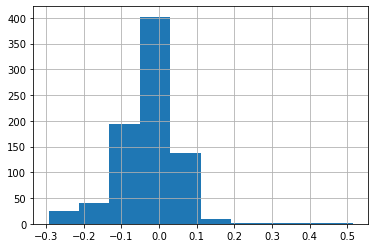

In [35]:


performance = test_df.copy()
performance['top_factor'] = performance['top_factor'].map(labels_reverse)
performance['top_factor_rets'] = [exposure.forward_returns_daily.loc[i][t] for i, t in zip(X_test.index, performance['top_factor'])]
performance['preds'] = forest_preds
performance['preds'] = performance['preds'].map(labels_reverse)
performance['preds_rets'] = [exposure.forward_returns_daily.loc[i][p] for i, p in zip(X_test.index, performance['preds'])]
performance.index = pd.to_datetime(performance.index)

performance.preds_rets.hist()



In [36]:


ok = exposure.forward_returns_monthly.copy()[:cutoff].iloc[:,:-2]
ok['scores'] = [(i,j) for i,j in zip(train_df['Real Yield_scores'], train_df['Yield Curve_scores'])]




In [37]:


def closest_combos(combo, in_index = False):

    assert isinstance(combo, tuple)
    
    min_error = 100
    errors = {}
    
    #tups = [(i,j) for i,j in zip(train_df['Real Yield_scores'], train_df['Yield Curve_scores'])]

    for rates in ok.scores:
        
        ry_error = abs(combo[0] - rates[0])
        yc_error = abs(combo[1] - rates[1])
        error = ry_error + yc_error
         
        errors[rates] = error
        
        if error <= min_error and error > 0:
            min_error = error
    
    mins = list(filter(lambda x: errors[x]==min_error, errors))
    
    if in_index:
        mins.append(combo)
    
    if len(mins) <= 2:
        
        more_mins = list(filter(lambda x: errors[x]==min_error+1, errors))
        
        extended = list( set(mins).union(set(more_mins)) )
        
        if len(extended) <= 3:
            
            even_more_mins = list(filter(lambda x: errors[x]==min_error+2, errors))
            
            return list( set(more_mins).union(set(even_more_mins)) )
        
        return extended
    
    return mins

#train_df.loc[ (train_df['Real Yield_scores'] == -3) & (train_df['Yield Curve_scores'] == -1) ]

close = closest_combos((-1,2), False)



In [38]:

#train_scores = 

train_tuple = pd.DataFrame()
train_tuple['top_factor'] = train_df.top_factor
train_tuple['scores'] = list(zip(train_df['Real Yield_scores'], train_df['Yield Curve_scores']))
train_tuple['rets'] = [ regular_df[:cutoff].loc[i].iloc[:-2].sort_values()[-1] for i in  regular_df[:cutoff].index]

real_train = regular_df[:cutoff].copy()

real_train['scores'] = train_tuple['scores']


In [39]:

preds = []
dexes = []
tolerance = []

for num, (ry, yc) in enumerate(zip(X_test['Real Yield_scores'], X_test['Yield Curve_scores'])):
    
    if len(train_df.loc[ ( train_df['Real Yield_scores'] == ry ) & ( train_df['Yield Curve_scores'] == yc ) ]) != 0:
        
        close = closest_combos((ry,yc), True)
    
    else:
        
        close = closest_combos((ry,yc), False)
    
    most_common = train_tuple.top_factor.loc[train_tuple.scores.isin(close)].value_counts().index[0]
    
    top_overall = train_tuple.loc[train_tuple.scores.isin(close)].sort_values(by="rets").top_factor[-1]
    
    # .index[0]
    start = .25
    bruh = real_train.loc[real_train.scores.isin(close)].iloc[:,:-4].quantile(start)
    
    #print(bruh)
    while not (bruh > 0).any():
        start += .005
        bruh = real_train.loc[real_train.scores.isin(close)].iloc[:,:-4].quantile(start)
    
    #print(bruh.sort_values())
    bruh = bruh.sort_values().index[-1]
    bruh = labels[bruh]
    
    
    if (top_overall == bruh) and (most_common == bruh):
        dexes.append(2)
        preds.append(top_overall)
    elif (top_overall == bruh) or (most_common == bruh):
        dexes.append(1)
        preds.append(bruh)
    elif (top_overall != bruh) and (most_common != bruh):
        dexes.append(0)
        preds.append(bruh)
    
    tolerance.append(start)
    
    #if num > 60:

#len(train_df.loc[ ( train_df['Real Yield_scores'] == 5 ) & ( train_df['Yield Curve_scores'] == -1 ) ])


<AxesSubplot:>

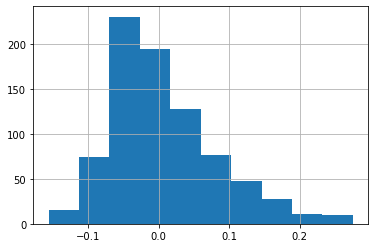

In [42]:

performance['my_algo_preds'] = preds
performance['my_algo_preds'] = performance['my_algo_preds'].map(labels_reverse)
performance['my_algo_preds_rets'] = [exposure.forward_returns_daily.loc[i][p] for i, p in zip(X_test.index, performance['my_algo_preds'])]
performance['match'] = dexes
performance['tolerance'] = tolerance


performance.my_algo_preds_rets.hist()



In [45]:


performance.loc[performance.match == 0].my_algo_preds_rets.mean()


-0.003924499229583974

In [50]:


#performance.loc[performance.match == 0].my_algo_preds_rets.mean()
#plt.scatter(performance.tolerance, performance.my_algo_preds_rets)


#performance[['tolerance', 'my_algo_preds_rets']].corr()

performance['diff_of_predictions'] = abs( performance['preds_rets'] - performance['my_algo_preds_rets'] )
performance['mean_of_predictions'] = ( performance['preds_rets'] + performance['my_algo_preds_rets'] ) / 2


performance.sort_values(by="my_algo_preds_rets")



,Real Yield_scores,Yield Curve_scores,top_factor,top_factor_rets,preds,preds_rets,my_algo_preds,my_algo_preds_rets,match,tolerance,mean_of_predictions,diff_of_predictions
Date,,,,,,,,,,,,
2020-03-03,-2.0,-0.0,QUALITY,0.1459,BOOK_TO_PRICE,-0.1560,BOOK_TO_PRICE,-0.1560,0,0.25,-0.15600,0.0000
2020-03-05,-3.0,0.0,QUALITY,0.1028,BOOK_TO_PRICE,-0.1383,BOOK_TO_PRICE,-0.1383,0,0.25,-0.13830,0.0000
2020-02-28,-2.0,-1.0,QUALITY,0.1359,DEFAULT,-0.0405,BOOK_TO_PRICE,-0.1377,0,0.27,-0.08910,0.0972
2020-03-04,-2.0,0.0,QUALITY,0.1185,BOOK_TO_PRICE,-0.1334,BOOK_TO_PRICE,-0.1334,0,0.25,-0.13340,0.0000
2020-02-21,-2.0,-1.0,QUALITY,0.2245,DEFAULT,-0.1908,BOOK_TO_PRICE,-0.1325,0,0.27,-0.16165,0.0583
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-03,-1.0,4.0,DEFAULT,0.2509,QUALITY,-0.1496,DEFAULT,0.2509,1,0.51,0.05065,0.4005
2021-01-29,-1.0,3.0,DEFAULT,0.2552,QUALITY,-0.1764,DEFAULT,0.2552,1,0.51,0.03940,0.4316
2021-01-25,-1.0,3.0,SIZE,0.1231,QUALITY,-0.2348,DEFAULT,0.2703,1,0.51,0.01775,0.5051


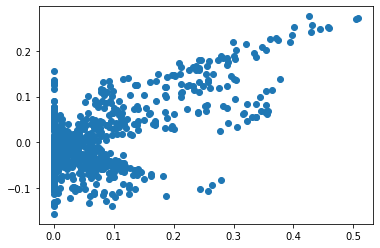

In [52]:



plt.scatter(performance.diff_of_predictions, performance.my_algo_preds_rets)




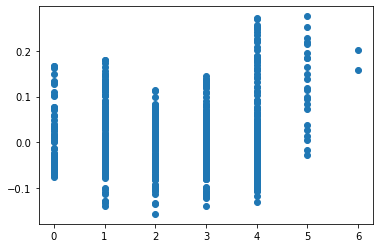

In [53]:


performance['score_diffs'] = abs(performance['Real Yield_scores'] - performance['Yield Curve_scores'])

#performance.sort_values(by="my_algo_preds_rets")

plt.scatter(performance.score_diffs, performance.my_algo_preds_rets)



In [ ]:


#exposure.mean_returns['Real Yield'].plot.bar(figsize=(25,15))

#exposure.mean_returns['Yield Curve'].plot.bar(figsize=(25,15))

#exposure.total_returns['Real Yield'][4].QUALITY